In [1]:
#%matplotlib notebook
import numpy as np, pandas as pd

import matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl

from joblib import Parallel, delayed

from scipy.optimize import linear_sum_assignment as lsa

from tools import *

sns.set_context('notebook', font_scale=1.2)

In this notebook, we include the code to conduct the synthetic experiments and reproduce the results reported in the paper.

In [6]:
def get_vectors(n_succs, n_modes):
    '''Returns the modes.'''
    rem = n_succs % n_modes
    div = int(np.floor(n_succs / n_modes))
    
    n_ones = [div+1 if i<rem else div for i in range(n_modes)]
    n_ones_cumsum = [0] + np.cumsum(n_ones)[:-1].tolist()
    
    vectors = []
    for i in range(n_modes):
        v = np.zeros(n_succs)
        v[n_ones_cumsum[i] : n_ones_cumsum[i]+n_ones[i]] = 1
        vectors.append(v.tolist())
    
    vectors = np.array(vectors).T
    vectors /= vectors.sum(axis=0)
    return vectors
    

def combine_vectors(vectors, dirichlet_params, n_preds, insert_originals=False):
    '''Returns random convex combinations of the modes with weights sampled from a Dirichlet distribution.'''
    ratios = np.random.dirichlet(dirichlet_params, size=n_preds)
    X = vectors @ ratios.T
    if insert_originals:
        X = np.hstack((X, vectors))
    return X

def combine_vectors_equal_weight(vectors, weight, n_preds, insert_originals=False):
    '''Wrapper for combine_vectors to sample from a symmetric Dirichlet distribution.'''
    return combine_vectors(vectors, np.ones(vectors.shape[1])*weight, n_preds, insert_originals=insert_originals)

In [ ]:
def sample_adjacency(T, n_trajs):
    '''Return observation count matrix A from underlying 'true' second-order matrix T.'''
    n_succs, n_preds = T.shape
    
    if type(n_trajs) is int or type(n_trajs) is float:
        n_trajs = [n_trajs] * n_preds
    assert len(n_trajs) == n_preds
    
        
    A = np.zeros_like(T)
    for i in range(n_preds):
        ks = np.random.choice(n_succs, p=T[:, i], size=int(n_trajs[i]))
        for k,n in list(zip(*np.unique(ks, return_counts=True))):
            A[k, i] += n
    return A

In [ ]:
def run_node(n_preds, n_succs, n_modes, dirichlet_weight):
    'Return PhysicalNode with A generated according to the exerpiemtn and processed up to rank 12.'
    modes = get_vectors(n_succs=n_succs, n_modes=n_modes)
    G = combine_vectors_equal_weight(modes, dirichlet_weight, n_preds)
    A = sample_adjacency(G, n_trajs=1000)
    
    node = PhysicalNode.from_adjacency_matrix(A)
    node.create_adjusted_transition_matrix()
    node.process(max_rank=12, n_candidates=10, initialise='kmeans', overlap_threshold=None)
    
    return node

In [5]:
def wrapper_run_node(n_modes, d_weight):
    print(n_modes, d_weight)
    return Parallel(n_jobs=-1)(delayed(run_node)(n_preds=50, n_succs=50, n_modes=n_modes, dirichlet_weight=d_weight) for _ in range(25))
    
result_nodes = {
    n_modes: {
        d_weight: wrapper_run_node(n_modes, d_weight)
        for d_weight in [0.5, 1.0, 1.5]
    } for n_modes in [2, 5, 10]
}

2 0.5
2 1.0
2 1.5
5 0.5
5 1.0
5 1.5
10 0.5
10 1.0
10 1.5


In [7]:
# Collect flow overlaps

result_overlaps = dict()
for n_modes in result_nodes:
    result_overlaps[n_modes] = dict()
    for d_weight in result_nodes[n_modes]:
        result_overlaps[n_modes][d_weight] = \
        np.array([list(n.dict_flow_overlap.values()) for n in result_nodes[n_modes][d_weight] ])

## Quality of fit of the concise model.

Reproducing Fig. 2B

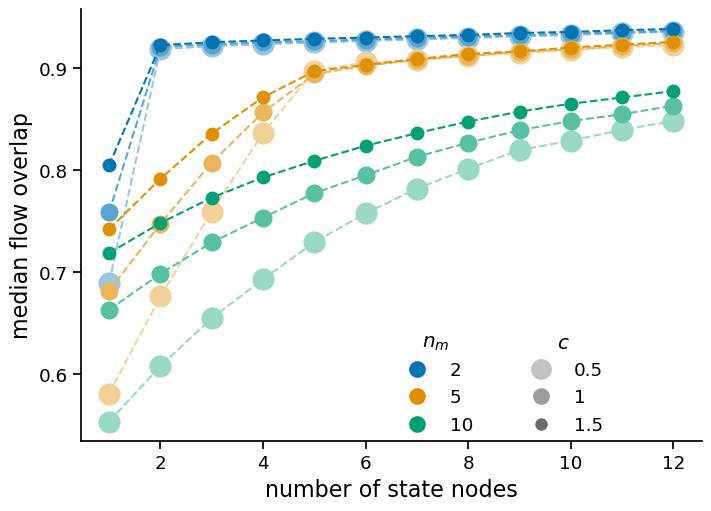

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,5),layout='constrained')

conc2alpha = {0.5: 0.4, 1: 0.65, 1.5:.99}
conc2ms = {0.5: 15, 1: 12, 1.5:9}
modes2color = dict(zip([2,5,10], sns.color_palette('colorblind')[:3]))


for conc in [0.5, 1, 1.5]:
    for modes in [2,5,10]:
        ax.plot(
            range(1, 13),
            np.median(result_overlaps[modes][conc], axis=0),
            marker = 'o',
            ls = '--',
            color = mpl.colors.LinearSegmentedColormap.from_list('', ['white', modes2color[modes]])(conc2alpha[conc]) , # modes2color[modes], 
            alpha = 1.,
            markersize = conc2ms[conc],
        )
        

sns.despine()
ax.set_yticks([.6, .7, .8, .9])
ax.set_xlabel('number of state nodes', fontsize=16)
ax.set_ylabel('median flow overlap', fontsize=16)

legend_handles = []
for k,v in modes2color.items():
    legend_handles.append(
            mpl.lines.Line2D([0], [0], label=f"{k}", marker='o', markersize=12, markerfacecolor=v, linestyle='', markeredgewidth=0)
    )
l1 = ax.legend(handles=legend_handles, frameon=False, title=r'$n_m$', loc=(0.5,0))  

legend_handles = []
for conc in [0.5, 1, 1.5]:
    legend_handles.append(
            mpl.lines.Line2D([0], [0], label=f"{conc}", marker='o', markersize=conc2ms[conc], markerfacecolor= mpl.colors.LinearSegmentedColormap.from_list('', ['white', 'dimgrey'])(conc2alpha[conc]), linestyle='', markeredgewidth=0)
    )
ax.legend(handles=legend_handles, frameon=False, title=r'$c$', loc=(0.7,0))
ax.add_artist(l1 )

## Interpretability of state nodes

Reproducing Fig. 2C

In [11]:
def get_cost_sample2states(n_modes, node, n_succs=50):
    ''' Returns the cost of the best matching. '''
    modes = get_vectors(n_succs=n_succs, n_modes=n_modes)
    best_data_vectors = []
    for ind_v in range(n_modes):
        # first, the data vector closes to the planted one
        best_idx = np.argmax([np.minimum(modes[:, ind_v], node.X[:, ind_x]).sum() for ind_x in range(50)])
        best_data_vectors.append(node.X[:, best_idx])
    best_data_vectors = np.array(best_data_vectors).T    
    
    cost = np.zeros((n_modes, n_modes))    
    sol = node.dict_solutions[n_modes]
    
    for ind_v in range(n_modes):
        for ind_x in range(n_modes):
            cost[ind_v, ind_x] = np.minimum(best_data_vectors[:, ind_v], sol.Xhat_out[:, ind_x]).sum()
    best = lsa(cost, maximize=True)
    return cost[best[0], best[1]].mean()

def get_cost_sample2states_null(n_modes, node, n_succs=50, n_null=50):
    ''' Returns the cost of the best matching for runs of the baseline. '''
    modes = get_vectors(n_succs=n_succs, n_modes=n_modes)
    best_data_vectors = []
    for ind_v in range(n_modes):
        # first, the data vector closes to the planted one
        best_idx = np.argmax([np.minimum(modes[:, ind_v], node.X[:, ind_x]).sum() for ind_x in range(50)])
        best_data_vectors.append(node.X[:, best_idx])
    best_data_vectors = np.array(best_data_vectors).T    
    
    list_costs = []
    for _ in range(n_null):
        random_states = combine_vectors_equal_weight(vectors=node.X, weight=1, n_preds=n_modes)
        cost = np.zeros((n_modes, n_modes))
        for ind_v in range(n_modes):
            for ind_x in range(n_modes):
                cost[ind_v, ind_x] = np.minimum(best_data_vectors[:, ind_v], random_states[:, ind_x]).sum()
        best = lsa(cost, maximize=True)
        list_costs.append( cost[best[0], best[1]].mean() )
    return list_costs

In [12]:
dict_costs = {modes: {conc: [ get_cost_sample2states(modes, n) for n in result_nodes[modes][conc] ] for conc in [.5, 1, 1.5]} for modes in [2,5,10]}

In [13]:
dict_costs_null = {modes: 
                   {conc: 
                    [i for subl in [ get_cost_sample2states_null(modes, n) for n in result_nodes[modes][conc] ] for i in subl]
                    for conc in [.5, 1, 1.5]} 
                    for modes in [2,5,10]}

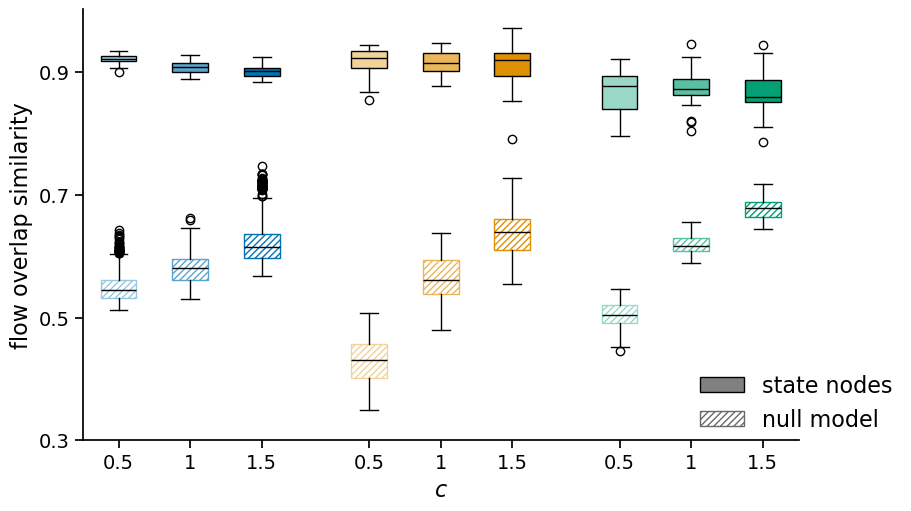

In [14]:
fig, ax = plt.subplots(1,1,figsize=(9,5),layout='constrained')

conc2alpha = {0.5: 0.4, 1: 0.65, 1.5:.99}
modes2color = dict(zip([2,5,10], sns.color_palette('colorblind')[:3]))
#

for pos, (modes, conc) in list(zip( [0,1,2, 3.5,4.5,5.5, 7,8,9] , [(i,j) for i in [2,5,10] for j in [0.5, 1,1.5]] )):
    ax.boxplot(
        [dict_costs[modes][conc]], 
        positions=[pos], 
        widths=.5,
        patch_artist=True, 
        boxprops=dict(facecolor= mpl.colors.LinearSegmentedColormap.from_list('', ['white', modes2color[modes]])(conc2alpha[conc]), alpha=1),
        medianprops=dict(color='black'),
    )
    ax.boxplot(
        [dict_costs_null[modes][conc]], 
        positions=[pos], 
        widths=.5,
        patch_artist=True, 
        boxprops=dict(edgecolor= mpl.colors.LinearSegmentedColormap.from_list('', ['white', modes2color[modes]])(conc2alpha[conc]), 
                      alpha=1, facecolor='white',
                      hatch='/'*5, ),
        medianprops=dict(color='black'),
    )
ax.set_yticks(np.arange(0.3, 0.91, 0.2), np.round(np.arange(0.3, 0.91, 0.2),1), fontsize=14)
ax.set_ylabel('flow overlap similarity', fontsize=16)
ax.set_xlabel(r'$c$', fontsize=16)
ax.set_xticks([0,1,2, 3.5,4.5,5.5, 7,8,9], [.5, 1, 1.5]*3, fontsize=14)

legend_handles = [
    mpl.patches.Patch(facecolor='grey', edgecolor='black', label=f"state nodes",) ,
    mpl.patches.Patch(facecolor='white', edgecolor='dimgrey', label=f"null model", hatch='/'*5,) 
]

ax.legend(handles=legend_handles, frameon=False, loc=(0.85,0), fontsize=16)

sns.despine()